В заключительной части проекта нами будет выполнено построение различных моделей машинного обучения с целью корректного прогнозирования зп по описанию и требованиям вакансии. В качестве оценки корректности работы модели мы использовали среднеквадратичную ошибку и поставили перед собой задачу ее минимизации. Так как все признаки категориальные, масштабирование призаконв не понадобится.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import linear_model
from typing import Iterable, List
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
import abc
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# pip install catboost==0.12.2

В EDA мы сделали предобработку данных, в них нет пропусков

In [2]:
df = pd.read_csv("df_for_ml.csv") 

## Гипотезы

Проверим некоторые гипотезы здесь (посмотрим на веса в линейных моделях):
1) Чем выше опыт работы - тем выше вклад в итоговую зп
2) постоянная работа будет оплачиваться выше временной
3) ЗП программистов выше ЗП аналитиков
4) Выплата зп в валюте положительно сказывается на итоговом размере оплаты труда
5) Локация в крупнейших городах (МСК и петербукрг) положительно сказывается на ЗП



# ML без обработки текстов

Мы будем предсказывать ЗП. 

In [3]:
df.head()

,Unnamed: 0,Организация,Описание,Тип_занятости,Локация,Ключевые навыки,Вакансия,ЗП_от,ЗП_до,Валюта,Профессия_id,Требования,Обязанности,Расписание,Опыт,Профессия,ЗП_сред,ЗП_сред_RUB,Локация_2,Сфера
0,1,Инновационная Экологическая Платформа,Ecoplatform - один из лидеров рынка фандоматов...,FULL_TIME,Москва,['React'],Frontend developer (React),100000.0,150000.0,RUR,96,Опыт разработки мобильных приложений на React ...,Разработка простых интеграций для программы ло...,remote,between1And3,"Программист, разработчик",125000.0,125000.0,Москва,Прога
1,3,НИТУ МИСИС,Университет науки и технологий МИСИС является ...,FULL_TIME,Москва,[],Data Scientist,150000.0,NaN,RUR,96,Высшее образование. Качественный опыт работы в...,Участие в проектировании и реализации решений ...,fullDay,between1And3,"Программист, разработчик",150000.0,150000.0,Москва,Прога
2,4,ООО «Вин-Маркет»,Кто мы: Aftermarket-DATA © — разработчик прогр...,FULL_TIME,Нижний Новгород,"['PHP', 'Git', 'MySQL', 'Redis', 'REST', 'SOAP...",Python-программист (Backend),90000.0,120000.0,RUR,96,"Python. PHP. HTML, CSS. JavaScript, jQuery. GI...",Участвовать во всех этапах проекта: от проекти...,fullDay,between1And3,"Программист, разработчик",105000.0,105000.0,Другое,Прога
3,5,Data-Power,Требуемый опыт работы: 3–6 лет Полная занятост...,FULL_TIME,Санкт-Петербург,"['DAX', 'PostgreSQL', 'SQL', 'Power BI', 'Powe...",Разработчик Power BI,100000.0,160000.0,RUR,96,...в <highlighttext>аналитике</highlighttext>:...,Разработка и внедрение <highlighttext>аналитик...,fullDay,between1And3,"Программист, разработчик",130000.0,130000.0,Санкт-Петербург,Прога
4,6,RTNO,"Привет! Мы компания RTNO, занимаемся аналитико...",FULL_TIME,Москва,"['Python', 'Сбор и анализ информации', 'Анализ...",Аналитик крипто проектов,75000.0,NaN,RUR,10,Поддержание актуальных знаний о развитии рынка...,Ежедневный анализ децентрализованных и централ...,fullDay,noExperience,Аналитик,75000.0,75000.0,Москва,Аналитика


In [4]:
df.shape

(1264, 20)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264 entries, 0 to 1263
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1264 non-null   int64  
 1   Организация      1264 non-null   object 
 2   Описание         1264 non-null   object 
 3   Тип_занятости    1264 non-null   object 
 4   Локация          1264 non-null   object 
 5   Ключевые навыки  1264 non-null   object 
 6   Вакансия         1264 non-null   object 
 7   ЗП_от            1048 non-null   float64
 8   ЗП_до            782 non-null    float64
 9   Валюта           1264 non-null   object 
 10  Профессия_id     1264 non-null   int64  
 11  Требования       1264 non-null   object 
 12  Обязанности      1264 non-null   object 
 13  Расписание       1264 non-null   object 
 14  Опыт             1264 non-null   object 
 15  Профессия        1264 non-null   object 
 16  ЗП_сред          1264 non-null   float64
 17  ЗП_сред_RUB   

Удалим признаки, с которыми я не буду работать:

In [3]:
df = df.drop(['Организация', 'Unnamed: 0', 'Описание', 'Вакансия', 'Профессия_id', 'Локация', 'Требования', 'Обязанности', 'ЗП_сред' ], axis=1)

In [5]:
df

,Тип_занятости,Ключевые навыки,ЗП_от,ЗП_до,Валюта,Расписание,Опыт,Профессия,ЗП_сред_RUB,Локация_2,Сфера
0,FULL_TIME,['React'],100000.0,150000.0,RUR,remote,between1And3,"Программист, разработчик",125000.0,Москва,Прога
1,FULL_TIME,[],150000.0,NaN,RUR,fullDay,between1And3,"Программист, разработчик",150000.0,Москва,Прога
2,FULL_TIME,"['PHP', 'Git', 'MySQL', 'Redis', 'REST', 'SOAP...",90000.0,120000.0,RUR,fullDay,between1And3,"Программист, разработчик",105000.0,Другое,Прога
3,FULL_TIME,"['DAX', 'PostgreSQL', 'SQL', 'Power BI', 'Powe...",100000.0,160000.0,RUR,fullDay,between1And3,"Программист, разработчик",130000.0,Санкт-Петербург,Прога
4,FULL_TIME,"['Python', 'Сбор и анализ информации', 'Анализ...",75000.0,NaN,RUR,fullDay,noExperience,Аналитик,75000.0,Москва,Аналитика
...,...,...,...,...,...,...,...,...,...,...,...
1259,FULL_TIME,"['Java', 'Scrum', 'PostgreSQL', 'JUnit', 'Упра...",300000.0,NaN,RUR,fullDay,between3And6,Тестировщик,300000.0,Санкт-Петербург,Прога
1260,FULL_TIME,"['Dart', 'Flutter', 'SOLID', 'Android', 'iOS',...",140000.0,NaN,RUR,remote,between1And3,"Программист, разработчик",140000.0,Другое,Прога
1261,FULL_TIME,[],180000.0,250000.0,RUR,remote,between3And6,"Программист, разработчик",215000.0,Москва,Прога
1262,FULL_TIME,"['MySQL', 'Symfony', 'ООП', 'PHP', 'Redis', 'P...",180000.0,NaN,RUR,remote,between3And6,"Программист, разработчик",180000.0,Другое,Прога


В столбце с ключевыми навыками лежат не списки, а строки. Преобразуем их в списки с навыками:

In [4]:
df['Ключевые навыки'] = df['Ключевые навыки'].apply(eval)

Попробую предсказывать среднюю ЗП

In [5]:
salary_info = df[['ЗП_от', 'ЗП_до']]
y = df['ЗП_сред_RUB']
X = df.drop(['ЗП_от', 'ЗП_до', 'ЗП_сред_RUB'], axis=1)

In [11]:
df[df['ЗП_сред_RUB']==0]

,Тип_занятости,Ключевые навыки,ЗП_от,ЗП_до,Валюта,Расписание,Опыт,Профессия,ЗП_сред_RUB,Локация_2,Сфера


Нет пропусков: вкусно!

Поработаем с столбцом ключевые навыки. Поскольку их слишком много для анализа, выделим 50 самых популярных. 

In [6]:
# Достанем навыки

r = X['Ключевые навыки']
X = X.drop(['Ключевые навыки'], axis=1)

In [7]:
X_dum = pd.get_dummies(X)
print(f"Data shape: {X_dum.shape}")
X_dum

Data shape: (1264, 42)


,Тип_занятости_FULL_TIME,Тип_занятости_INTERN,Тип_занятости_PART_TIME,Тип_занятости_TEMPORARY,Валюта_EUR,Валюта_RUR,Валюта_USD,Расписание_flexible,Расписание_fullDay,Расписание_remote,...,Профессия_Технический писатель,"Профессия_Финансовый аналитик, инвестиционный аналитик",Локация_2_Другое,Локация_2_Екатеринбург,Локация_2_Казань,Локация_2_Москва,Локация_2_Новосибирск,Локация_2_Санкт-Петербург,Сфера_Аналитика,Сфера_Прога
0,True,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
1,True,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,True,False,False,False,True
2,True,False,False,False,False,True,False,False,True,False,...,False,False,True,False,False,False,False,False,False,True
3,True,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
4,True,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,True,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
1260,True,False,False,False,False,True,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
1261,True,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
1262,True,False,False,False,False,True,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True


In [8]:
X = X.join(r)

# Считаем частоту каждого навыка
all_skills = [skill for sublist in X['Ключевые навыки'] for skill in sublist]
skill_counts = Counter(all_skills)

# Определяем топ-50 популярных навыков
top_skills = [skill for skill, count in skill_counts.most_common(50)]

# Инициализация и применение MultiLabelBinarizer для one-hot encoding топ-50 навыков
mlb = MultiLabelBinarizer(classes=top_skills)
skills_encoded = mlb.fit_transform(X['Ключевые навыки'])

# Преобразуем результат в датафрейм и добавим обратно к основному датафрейму
skills_df = pd.DataFrame(skills_encoded, columns=mlb.classes_)


Нужный нам датафрейм будет атким:

In [9]:
X1 = X_dum.join(skills_df)
X1

,Тип_занятости_FULL_TIME,Тип_занятости_INTERN,Тип_занятости_PART_TIME,Тип_занятости_TEMPORARY,Валюта_EUR,Валюта_RUR,Валюта_USD,Расписание_flexible,Расписание_fullDay,Расписание_remote,...,Spring Framework,Backend,MongoDB,Frontend,DWH,Тестирование,Atlassian Jira,Symfony,Vue,Spark
0,True,False,False,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,0,0,0
1,True,False,False,False,False,True,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,False,True,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
3,True,False,False,False,False,True,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
4,True,False,False,False,False,True,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,True,False,False,False,False,True,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
1260,True,False,False,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,0,0,0
1261,True,False,False,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,0,0,0
1262,True,False,False,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,1,0,0


Разделим выборку на тест и трейн. 

In [10]:
np.random.seed(4)
X_train, X_test, y_train, y_test = train_test_split(X1, y, train_size=0.7)


## Линейная регрессия

In [11]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

In [34]:
mean_squared_error(y_train, y_pred_train)

6220570276.321833

In [126]:
MSE_linreg = mean_squared_error(y_test, y_pred_test)
MSE_linreg

3.1197538060338704e+31

<a href="https://imgbb.com/"><img src="https://i.ibb.co/rdmBjf7/c8ea7e16a57d333362838c6a3730dbc6.jpg" alt="c8ea7e16a57d333362838c6a3730dbc6" border="0"></a>

In [15]:
# Создадим таблицу с весами
lr_base_feature_coefs = pd.DataFrame(
    data=reg.coef_, index=X1.columns, columns=['Coef']
)

lr_base_feature_coefs

,Coef
Тип_занятости_FULL_TIME,-7.960642e+17
Тип_занятости_INTERN,-7.960642e+17
Тип_занятости_PART_TIME,-7.960642e+17
Тип_занятости_TEMPORARY,-7.960642e+17
Валюта_EUR,3.772647e+18
...,...
Тестирование,-2.188800e+04
Atlassian Jira,-2.713600e+04
Symfony,3.584000e+03
Vue,-1.612800e+04


Большие веса добавим регуляризацию!

## Линейная регрессия с регуляризацией

In [12]:
clf = linear_model.Lasso(alpha=1)
clf.fit(X_train, y_train)
y_pred_lasso_train = clf.predict(X_train)
y_pred_lasso_test = clf.predict(X_test)

print(f'MSE Linreg with Lasso train: {mean_squared_error(y_train, y_pred_lasso_train)}')
print(f'MSE Linreg with Lasso test: {mean_squared_error(y_test, y_pred_lasso_test)}')

clf1 = linear_model.Ridge(alpha=1)
clf1.fit(X_train, y_train)
y_pred_ridge_train = clf1.predict(X_train)
y_pred_ridge_test = clf1.predict(X_test)

print(f'MSE Linreg with Ridge train: {mean_squared_error(y_train, y_pred_ridge_train)}')
print(f'MSE Linreg with Ridge test: {mean_squared_error(y_test, y_pred_ridge_test)}')

MSE Linreg with Lasso train: 6170161158.287527
MSE Linreg with Lasso test: 6315654632.6511965
MSE Linreg with Ridge train: 6179991640.387848
MSE Linreg with Ridge test: 6192471917.238546


In [21]:
# Создадим таблицу с весами
lr_base_feature_coefs = pd.DataFrame(
    data=clf.coef_, index=X1.columns, columns=['Coef Lasso']
)

lr_base_feature_coefs

,Coef Lasso
Тип_занятости_FULL_TIME,38394.744156
Тип_занятости_INTERN,4405.894035
Тип_занятости_PART_TIME,-118.059227
Тип_занятости_TEMPORARY,-6592.161982
Валюта_EUR,48429.791467
...,...
Тестирование,-19226.209374
Atlassian Jira,-23724.559198
Symfony,6592.527968
Vue,-14774.742409


In [30]:
# Создадим таблицу с весами
lr_base_feature_coefs = pd.DataFrame(
    data=clf1.coef_, index=X1.columns, columns=['Coef Ridge']
)

lr_base_feature_coefs.head(50)

,Coef Ridge
Тип_занятости_FULL_TIME,29529.908719
Тип_занятости_INTERN,-6285.632641
Тип_занятости_PART_TIME,-9171.325103
Тип_занятости_TEMPORARY,-14072.950976
Валюта_EUR,65930.307185
Валюта_RUR,-91862.332336
Валюта_USD,25932.025151
Расписание_flexible,-9666.195263
Расписание_fullDay,4663.454393
Расписание_remote,5002.740870


Вывод: Таким образом, мы смогли добиться лишь незначительного снижения средних ошибок, а рассмотренные веса по-прежнему остаются достаточно большими. Следовательно, ограничения влияния выбросов не дает значительных результатов по минимизации нашей функции потерь, возможно, выбросов оказывается и не так уж и много.

## Гипотезы

Проверим некоторые гипотезы здесь (посмотрим на веса в линейных моделях):
1) Чем выше опыт работы - тем выше вклад в итоговую зп
2) постоянная работа будет оплачиваться выше временной
3) ЗП программистов выше ЗП аналитиков
4) Выплата зп в валюте положительно сказывается на итоговом размере оплаты труда
5) Локация в крупнейших городах (МСК и петербукрг) положительно сказывается на ЗП

Мама дорогая, гипотезы подтвердились (из знака весов видно).

## Градиентный спуск

Параметры theta после градиентного спуска:
[[81151.37346352114]
 [51001.03244028446]
 [9969.26320232039]
 [6444.767532499231]
 [13734.941749009153]
 [73967.91934853271]
 [-54611.29737019802]
 [61792.618661716035]
 [12208.666198976265]
 [32852.94202773255]
 [36086.64178188389]
 [-23174.7989395054]
 [50355.26888203424]
 [134994.3339595666]
 [-81020.27065849621]
 [-8788.167696373494]
 [25148.216617638143]
 [2371.138104269559]
 [2697.9485845007275]
 [49400.98048629778]
 [20015.95307685532]
 [-12685.495520536864]
 [-11594.454143677629]
 [-9434.050421541102]
 [3740.0616922535196]
 [80675.48757792935]
 [8673.06687248048]
 [-12739.733535312986]
 [2239.53189767311]
 [-43269.14619286038]
 [32070.309851399452]
 [23049.77368343297]
 [-41168.21536185727]
 [752.9207095874427]
 [-30006.811530005823]
 [-4621.130953641612]
 [1118.19011494274]
 [11940.768068442087]
 [43385.39339143317]
 [10828.181282310203]
 [18498.15441381082]
 [23139.93307718676]
 [58011.17769929512]
 [-23994.88444175855]
 [10406.8259

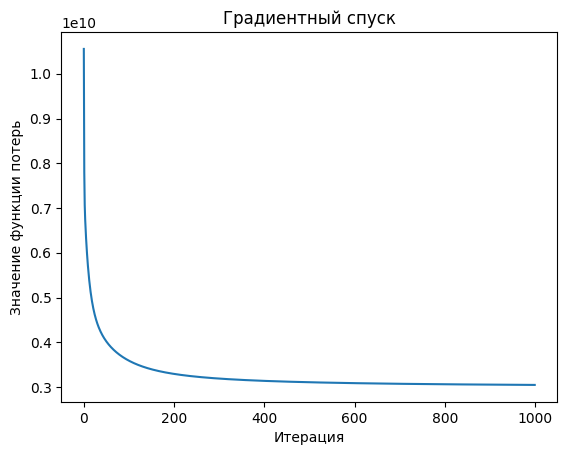

In [60]:
X_b = np.c_[np.ones((X1.shape[0], 1)), X1]

y = np.array(y).reshape(-1, 1)

def mse(X, y, theta):
    m = len(y)
    predictions = X.dot(theta)
    cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
    return cost

def gradient_descent(X, y, theta, learning_rate, iterations):
    m = len(y)
    cost_history = np.zeros(iterations)
    
    for it in range(iterations):
        gradients = (1 / m) * X.T.dot(X.dot(theta) - y)
        theta = theta - learning_rate * gradients
        cost_history[it] = mse(X, y, theta)
        
    return theta, cost_history

theta = np.random.randn(X_b.shape[1], 1)  # Случайная инициализация
learning_rate = 0.1
iterations = 1000

theta_best, cost_history = gradient_descent(X_b, y, theta, learning_rate, iterations)

print("Параметры theta после градиентного спуска:")
print(theta_best)

print("Значения функции потерь для последних 10 итераций:")
print(cost_history[-10:])

plt.plot(range(iterations), cost_history)
plt.xlabel("Итерация")
plt.ylabel("Значение функции потерь")
plt.title("Градиентный спуск")
plt.show()


## Показ мод (другие модели):

In [158]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(mean_squared_error(y_train, y_pred_train))
print(mean_squared_error(y_test, y_pred))

6220570276.321833
3.1197538060338704e+31


In [172]:
model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(mean_squared_error(y_train, y_pred_train))
print(mean_squared_error(y_test, y_pred))

6179991640.387848
6192471917.238546


## Решающее дерево

In [160]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(mean_squared_error(y_train, y_pred_train))
print(mean_squared_error(y_test, y_pred))

1046161115.2037805
14292545869.908966


## Случайный лес

In [168]:
model = RandomForestRegressor(n_estimators=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(mean_squared_error(y_train, y_pred_train))
print(mean_squared_error(y_test, y_pred))


1934575761.2658923
8243565569.861138


## Градиентный бустинг

In [166]:
model = GradientBoostingRegressor(n_estimators=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(mean_squared_error(y_train, y_pred_train))
print(mean_squared_error(y_test, y_pred))

2358317843.594649
7153649733.907619


## Catboost от яндекса


Накатим библиотеку от Яндекса:
Возьму незакодированные данные, но в этот раз не получится поработать с списоком навыков 

### Незакодированные признаки

In [25]:
X2 = X.drop(['Ключевые навыки'], axis=1)
cat_features = X2.columns.tolist()

np.random.seed(4)
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X2, y, train_size=0.7)

model = CatBoostRegressor(cat_features=cat_features, iterations=1000, learning_rate=0.1)
model.fit(X_trainc, y_trainc)
y_predc = model.predict(X_testc)
y_pred_trainc = model.predict(X_trainc)
print(mean_squared_error(y_trainc, y_pred_trainc))
print(mean_squared_error(y_testc, y_predc))


0:	learn: 116093.2365902	total: 41.5ms	remaining: 41.4s
1:	learn: 112319.4026211	total: 128ms	remaining: 1m 3s
2:	learn: 108620.6482199	total: 217ms	remaining: 1m 12s
3:	learn: 105478.6579410	total: 293ms	remaining: 1m 12s
4:	learn: 103068.9800399	total: 381ms	remaining: 1m 15s
5:	learn: 100785.0078061	total: 425ms	remaining: 1m 10s
6:	learn: 98637.8573260	total: 513ms	remaining: 1m 12s
7:	learn: 96880.7323922	total: 574ms	remaining: 1m 11s
8:	learn: 95371.8263327	total: 627ms	remaining: 1m 8s
9:	learn: 93828.0315992	total: 680ms	remaining: 1m 7s
10:	learn: 92545.4544688	total: 732ms	remaining: 1m 5s
11:	learn: 91293.1390656	total: 793ms	remaining: 1m 5s
12:	learn: 90379.4614033	total: 847ms	remaining: 1m 4s
13:	learn: 89776.5449436	total: 899ms	remaining: 1m 3s
14:	learn: 89000.1883374	total: 951ms	remaining: 1m 2s
15:	learn: 88739.4016664	total: 968ms	remaining: 59.6s
16:	learn: 88197.3962359	total: 1.03s	remaining: 59.4s
17:	learn: 87626.2462884	total: 1.08s	remaining: 58.9s
18:	lea

In [29]:
X2.head()     # на этих данных обучалась модель

,Тип_занятости,Валюта,Расписание,Опыт,Профессия,Локация_2,Сфера
0,FULL_TIME,RUR,remote,between1And3,"Программист, разработчик",Москва,Прога
1,FULL_TIME,RUR,fullDay,between1And3,"Программист, разработчик",Москва,Прога
2,FULL_TIME,RUR,fullDay,between1And3,"Программист, разработчик",Другое,Прога
3,FULL_TIME,RUR,fullDay,between1And3,"Программист, разработчик",Санкт-Петербург,Прога
4,FULL_TIME,RUR,fullDay,noExperience,Аналитик,Москва,Аналитика


А если с закодирвоанными?

### Закодированные признаки

In [26]:
cat_features = X1.columns.tolist()

np.random.seed(4)
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X1, y, train_size=0.7)

model = CatBoostRegressor(cat_features=cat_features, iterations=1000, learning_rate=0.1)
model.fit(X_trainc, y_trainc)
y_predc = model.predict(X_testc)
y_pred_trainc = model.predict(X_trainc)
print(mean_squared_error(y_trainc, y_pred_trainc))
print(mean_squared_error(y_testc, y_predc))

0:	learn: 115582.0856102	total: 4.53ms	remaining: 4.53s
1:	learn: 111534.9461348	total: 9.78ms	remaining: 4.88s
2:	learn: 107808.3415541	total: 14.6ms	remaining: 4.87s
3:	learn: 104402.6228198	total: 19.3ms	remaining: 4.8s
4:	learn: 101535.2381131	total: 23.6ms	remaining: 4.7s
5:	learn: 99611.0719879	total: 30.7ms	remaining: 5.09s
6:	learn: 97293.9180361	total: 35.4ms	remaining: 5.03s
7:	learn: 95364.5356590	total: 40ms	remaining: 4.96s
8:	learn: 93581.9041240	total: 45ms	remaining: 4.96s
9:	learn: 92110.3791502	total: 50.4ms	remaining: 4.99s
10:	learn: 90791.6518702	total: 55ms	remaining: 4.95s
11:	learn: 89742.2867727	total: 60.8ms	remaining: 5s
12:	learn: 89027.3894034	total: 65.6ms	remaining: 4.98s
13:	learn: 88167.4718608	total: 70.7ms	remaining: 4.98s
14:	learn: 87063.0357751	total: 76ms	remaining: 4.99s
15:	learn: 86370.7315043	total: 79.6ms	remaining: 4.89s
16:	learn: 85359.2799688	total: 85ms	remaining: 4.91s
17:	learn: 84754.1511393	total: 90.2ms	remaining: 4.92s
18:	learn: 8

In [30]:
X1.head()        # на этих данных обучалась модель

,Тип_занятости_FULL_TIME,Тип_занятости_INTERN,Тип_занятости_PART_TIME,Тип_занятости_TEMPORARY,Валюта_EUR,Валюта_RUR,Валюта_USD,Расписание_flexible,Расписание_fullDay,Расписание_remote,...,Spring Framework,Backend,MongoDB,Frontend,DWH,Тестирование,Atlassian Jira,Symfony,Vue,Spark
0,True,False,False,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,0,0,0
1,True,False,False,False,False,True,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,False,True,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
3,True,False,False,False,False,True,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
4,True,False,False,False,False,True,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0


А если возьмем незакодирвоанные признаки и добавим к ним закодированные ключевые навыки?

### Комбинация закодированных и незакодированных признаков

In [27]:
X2 = X.drop(['Ключевые навыки'], axis=1)
X3 = X2.join(skills_df)

cat_features = X3.columns.tolist()

np.random.seed(4)
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X3, y, train_size=0.7)

model = CatBoostRegressor(cat_features=cat_features, iterations=1000, learning_rate=0.1)
model.fit(X_trainc, y_trainc)
y_predc = model.predict(X_testc)
y_pred_trainc = model.predict(X_trainc)
print(mean_squared_error(y_trainc, y_pred_trainc))
print(mean_squared_error(y_testc, y_predc))


0:	learn: 116801.2332637	total: 80.3ms	remaining: 1m 20s
1:	learn: 112784.8632139	total: 177ms	remaining: 1m 28s
2:	learn: 109714.7963010	total: 258ms	remaining: 1m 25s
3:	learn: 106113.7233282	total: 339ms	remaining: 1m 24s
4:	learn: 103137.5615492	total: 416ms	remaining: 1m 22s
5:	learn: 100644.2975687	total: 488ms	remaining: 1m 20s
6:	learn: 98342.0744336	total: 559ms	remaining: 1m 19s
7:	learn: 96590.8298828	total: 634ms	remaining: 1m 18s
8:	learn: 94790.0083730	total: 712ms	remaining: 1m 18s
9:	learn: 93344.8415634	total: 784ms	remaining: 1m 17s
10:	learn: 92187.8513538	total: 857ms	remaining: 1m 17s
11:	learn: 90944.4845529	total: 930ms	remaining: 1m 16s
12:	learn: 89792.2775288	total: 984ms	remaining: 1m 14s
13:	learn: 89001.3536256	total: 1.04s	remaining: 1m 13s
14:	learn: 88274.1800249	total: 1.09s	remaining: 1m 11s
15:	learn: 87632.6082667	total: 1.14s	remaining: 1m 10s
16:	learn: 86947.5489417	total: 1.2s	remaining: 1m 9s
17:	learn: 86447.6372806	total: 1.25s	remaining: 1m 8

In [31]:
X3.head()        # на этих данных обучалась модель

,Тип_занятости,Валюта,Расписание,Опыт,Профессия,Локация_2,Сфера,Git,Python,JavaScript,...,Spring Framework,Backend,MongoDB,Frontend,DWH,Тестирование,Atlassian Jira,Symfony,Vue,Spark
0,FULL_TIME,RUR,remote,between1And3,"Программист, разработчик",Москва,Прога,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FULL_TIME,RUR,fullDay,between1And3,"Программист, разработчик",Москва,Прога,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,FULL_TIME,RUR,fullDay,between1And3,"Программист, разработчик",Другое,Прога,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,FULL_TIME,RUR,fullDay,between1And3,"Программист, разработчик",Санкт-Петербург,Прога,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FULL_TIME,RUR,fullDay,noExperience,Аналитик,Москва,Аналитика,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Вывод: 

Таким образом, среди примененных нами стандартных моделей машинного обучения наилучшие результаты показали линейная регрессия с Lasso, Градиентный бустинг и Catboost, так как они показывали наименьшие ошибки на трейне и тесте.